In [1]:
%matplotlib notebook

In [2]:
from firedrake import *
from pyroteus.error_estimation import form2estimator
from contexttimer import Timer

In [3]:
import matplotlib.pyplot as plt

In [4]:
PETSc.Sys.popErrorHandler()

In [5]:
p = 1
family = "CG"
resolutions = [10, 20, 40, 80, 160, 320]
# resolutions = [10, 20, 40]

In [6]:
def kernel(V):
    x, y = SpatialCoordinate(V.mesh())
    return x*y*(x-1)*(y-1)

In [7]:
sp = {
    "mat_type": "aij",
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
}
sp_mass_inv = {
    "mat_type": "matfree",
    "ksp_type": "preonly",
    "pc_type": "python",
    "pc_python_type": "firedrake.MassInvPC",
}
sp_ibp = {
    "ksp_type": "gmres",
    "ksp_gmres_restart": 20,
    "ksp_rtol": 1.0e-05,
    "pc_type": "sor",
}

In [8]:
def solve_forward(V):
    u, v = TrialFunction(V), TestFunction(V)
    x, y = SpatialCoordinate(V.mesh())
    f = 2*pi*pi*sin(pi*x)*sin(pi*y)
    
    a = inner(grad(u), grad(v))*dx
    L = f*v*dx
    
    if family == "DG":
        n = FacetNormal(mesh)
        l_normal = CellVolume(mesh)/FacetArea(mesh)
        sigma = Constant((p + 1)*(p + 2)/2)/l_normal
        sigma_max = max_value(sigma('+'), sigma('-'))
        a += sigma_max*inner(jump(v, n), jump(u, n))*dS
        a += -inner(avg(grad(v)), jump(u, n))*dS
        a += -inner(jump(v, n), avg(grad(u)))*dS
        a += -v*dot(grad(0.5*u), n)*ds
    
    uh = Function(V)
    bc = [] if family == "DG" else DirichletBC(V, 0, 'on_boundary')
    solve(a == L, uh, bcs=bc, solver_parameters=sp)
    return uh

In [9]:
def solve_adjoint(V):
    u, v = TrialFunction(V), TestFunction(V)
    f = kernel(V)
    
    a = inner(grad(u), grad(v))*dx
    L = inner(grad(f), grad(v))*dx
    
    if family == "DG":
        n = FacetNormal(mesh)
        l_normal = CellVolume(mesh)/FacetArea(mesh)
        sigma = Constant((p + 1)*(p + 2)/2)/l_normal
        sigma_max = max_value(sigma('+'), sigma('-'))
        a += sigma_max*inner(jump(v, n), jump(u, n))*dS
        a += -inner(avg(grad(v)), jump(u, n))*dS
        a += -inner(jump(v, n), avg(grad(u)))*dS
        a += -v*dot(grad(0.5*u), n)*ds
    
    uh = Function(V)
    bc = [] if family == "DG" else DirichletBC(V, 0, 'on_boundary')
    solve(a == L, uh, bcs=bc, solver_parameters=sp)
    return uh

In [10]:
def exact_solution(V):
    x, y = SpatialCoordinate(V.mesh())
    return sin(pi*x)*sin(pi*y)

In [11]:
def qoi(u, V=None):
    V = V or u.function_space()
    return assemble(inner(grad(u), grad(kernel(V)))*dx)

In [12]:
qoi_exact = 32/pi**4

In [13]:
dofs = []
L2_errors = []
qois = []
qoi_errors = []
print("DoFs    L2 error   QoI error")
for N in resolutions:
    mesh = UnitSquareMesh(N, N)
    Vc = FunctionSpace(mesh, family, p)
    uc = solve_forward(Vc)
    uc_exact = exact_solution(Vc)
    
    dof = Vc.dof_count
    Ju = qoi(uc, Vc)
    Je = abs(qoi_exact - Ju)/qoi_exact
    L2_error = errornorm(uc_exact, uc)/norm(uc_exact)

    print(f"{dof:6d}  {L2_error:.4e}  {Je:.4e}")
    dofs.append(dof)
    L2_errors.append(L2_error)
    qois.append(Ju)
    qoi_errors.append(Je)

DoFs    L2 error   QoI error
   121  2.7279e-02  2.4419e-02
   441  6.8980e-03  6.1525e-03
  1681  1.7295e-03  1.5411e-03
  6561  4.3269e-04  3.8547e-04
 25921  1.0819e-04  9.6379e-05
103041  2.7049e-05  2.4095e-05


<IPython.core.display.Javascript object>


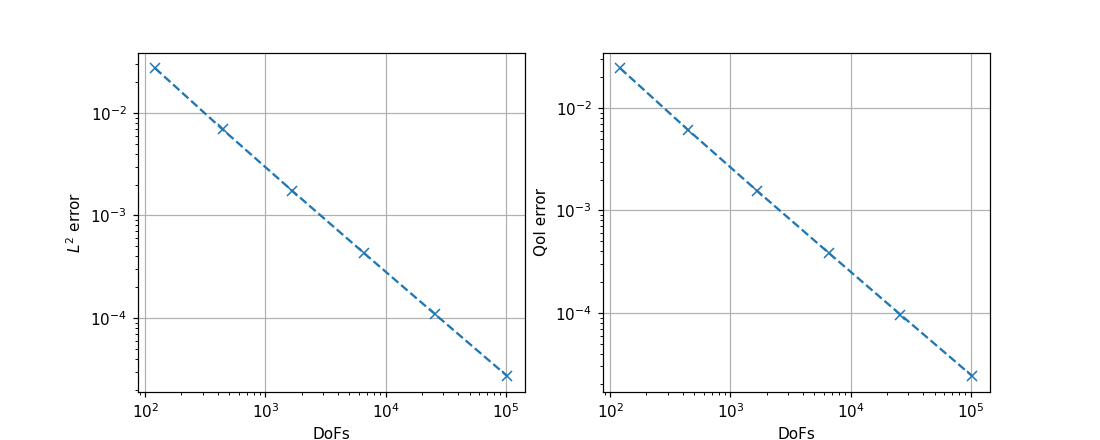

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

axes[0].loglog(dofs, L2_errors, '--x')
axes[0].set_xlabel("DoFs")
axes[0].set_ylabel(r"$L^2$ error")
axes[0].grid(True)

axes[1].loglog(dofs, qoi_errors, '--x')
axes[1].set_xlabel("DoFs")
axes[1].set_ylabel("QoI error")
axes[1].grid(True)

In [15]:
def indicate_GEp(uc, uc_adj):
    Vc = uc.function_space()
    mesh = Vc.mesh()
    Vf = FunctionSpace(mesh, family, p+1)
    uf = solve_forward(Vf)
    P0 = FunctionSpace(mesh, "DG", 0)
    p0test = TestFunction(P0)
    n = FacetNormal(mesh)
    loc = -p0test*dot(grad(kernel(Vc) - uc_adj), n)*(uf - uc)
    i_GEp = Function(P0)
    solve(TrialFunction(P0)*p0test*dx == (loc('+') + loc('-'))*dS + loc*ds, i_GEp, solver_parameters=sp_mass_inv)
    i_GEp += assemble(p0test*div(grad(kernel(Vc) - uc_adj))*(uf - uc)*dx)
    return i_GEp

In [16]:
def indicate_GEh(uc, uc_adj):
    Vc = uc.function_space()
    mesh = Vc.mesh()
    Vf = FunctionSpace(mh[1], family, p)
    uf = solve_forward(Vf)
    uc_prolong = Function(Vf)
    uc_adj_prolong = Function(Vf)
    x_prolong = Function(Vf)
    y_prolong = Function(Vf)
    prolong(uc, uc_prolong)
    prolong(uc_adj, uc_adj_prolong)
    prolong(interpolate(x, Vc), x_prolong)
    prolong(interpolate(y, Vc), y_prolong)
    k_prolong = x_prolong*(x_prolong-1)*y_prolong*(y_prolong-1)
    P0 = FunctionSpace(mh[1], "DG", 0)
    p0test = TestFunction(P0)
    n = FacetNormal(mh[1])
    loc = -p0test*dot(grad(k_prolong - uc_adj_prolong), n)*(uf - uc_prolong)
    _i_GEh = Function(P0)
    solve(TrialFunction(P0)*p0test*dx == (loc('+') + loc('-'))*dS + loc*ds, _i_GEh, solver_parameters=sp_mass_inv)
    _i_GEh += assemble(p0test*div(grad(k_prolong - uc_adj_prolong))*(uf - uc_prolong)*dx)
    i_GEh = Function(FunctionSpace(mesh, "DG", 0))
    i_GEh.project(_i_GEh)
    i_GEh *= 4  # Four times fewer cells
    return i_GEh

In [17]:
def indicate_DQ(uc, uc_adj):
    Vc = uc.function_space()
    mesh = Vc.mesh()
    P0 = FunctionSpace(mesh, "DG", 0)
    p0test = TestFunction(P0)
    n = FacetNormal(mesh)
    loc = p0test*dot(grad(kernel(Vc) - uc_adj), n)*dot(grad(kernel(Vc) - uc_adj), n)
    flux = Function(P0)
    solve(TrialFunction(P0)*p0test*dx == (loc('+') + loc('-'))*dS + loc*ds, flux, solver_parameters=sp_mass_inv)
    cell = assemble(p0test*div(grad(kernel(Vc) - uc_adj))*div(grad(kernel(Vc) - uc_adj))*dx)
    vP1 = VectorFunctionSpace(mesh, "CG", 1)
    g, psi = TrialFunction(vP1), TestFunction(vP1)
    a = inner(g, psi)*dx
    L = uc*dot(psi, n)*ds - uc*div(psi)*dx
    g = Function(vP1)
    solve(a == L, g, solver_parameters=sp_ibp)
    return project((sqrt(abs(cell)) + sqrt(abs(flux)/CellSize(mesh)))*sqrt(div(g)*div(g)), P0)

In [18]:
GEh, GEp, DQ = [], [], []
t_GEh, t_GEp, t_DQ = [], [], []
t_adj = []
print("DoFs    cells    GEp          GEh          DQ")
for N in resolutions:
    mesh = UnitSquareMesh(N, N)
    x, y = SpatialCoordinate(mesh)
    mh = MeshHierarchy(mesh, 1)
    
    V = FunctionSpace(mesh, family, p)
    dof = V.dof_count
    u = solve_forward(V)
    with Timer() as t:
        u_adj = solve_adjoint(V)
    t_adj.append(t.elapsed)
    
    # GE_p
    with Timer() as t:
        i_GEp = indicate_GEp(u, u_adj)
        e_GEp = i_GEp.vector().gather().sum()
    GEp.append(e_GEp)
    t_GEp.append(t.elapsed)
    
    # GE_h
    with Timer() as t:
        i_GEh = indicate_GEh(u,u_adj)
        e_GEh = i_GEh.vector().gather().sum()
    GEh.append(e_GEh)
    t_GEh.append(t.elapsed)
    
    # DQ
    with Timer() as t:
        i_DQ = indicate_DQ(u, u_adj)
        e_DQ = i_DQ.vector().gather().sum()
    DQ.append(e_DQ)
    t_DQ.append(t.elapsed)
    
    print(f"{dof:6d}  {mesh.num_cells():6d}   {e_GEp:.4e}  {e_GEh:.4e}  {e_DQ:.4e}")

DoFs    cells    GEp          GEh          DQ
   121     200   -7.9976e-03  -6.0007e-03  8.4302e+02
   441     800   -2.0196e-03  -1.5149e-03  3.1188e+03
  1681    3200   -5.0618e-04  -3.7965e-04  1.1782e+04
  6561   12800   -1.2663e-04  -9.4967e-05  4.5458e+04
 25921   51200   -3.1669e-05  -2.3710e-05  1.7795e+05
103041  204800   -8.0607e-06  -5.1842e-06  7.0319e+05


In [19]:
qois = np.array(qois)
qoi_errors = np.array(qoi_errors)
t_adj = np.array(t_adj)
GEp = np.array(GEp)
GEh = np.array(GEh)
DQ = np.array(DQ)
Ieff_GEp = abs(GEp/qois/qoi_errors)
Ieff_GEh = abs(GEh/qois/qoi_errors)
Ieff_DQ = abs(DQ/qois/qoi_errors)
tn_GEp = t_GEp/t_adj
tn_GEh = t_GEh/t_adj
tn_DQ = t_DQ/t_adj

<IPython.core.display.Javascript object>


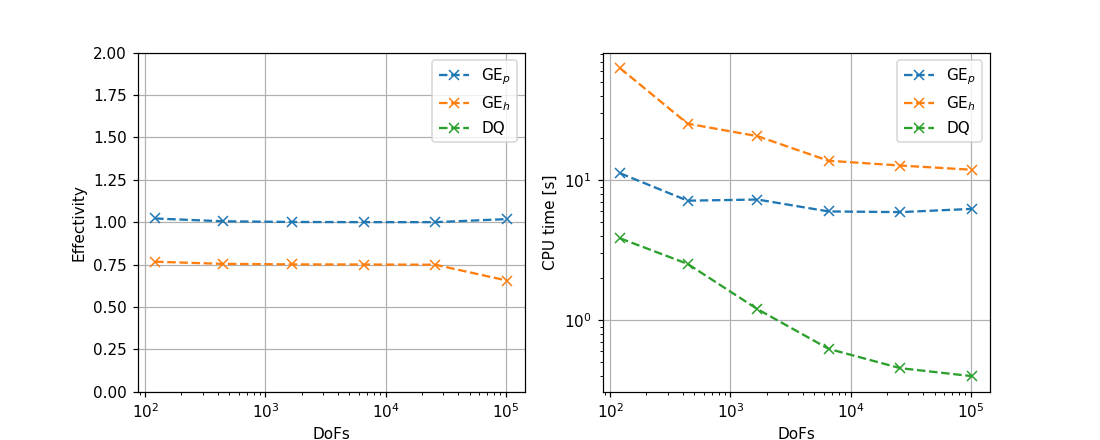

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

axes[0].semilogx(dofs, Ieff_GEp, '--x', label=r'GE$_p$')
axes[0].semilogx(dofs, Ieff_GEh, '--x', label=r'GE$_h$')
axes[0].semilogx(dofs, Ieff_DQ, '--x', label='DQ')
axes[0].set_xlabel("DoFs")
axes[0].set_ylabel("Effectivity")
axes[0].grid(True)
axes[0].set_ylim([0, 2])
axes[0].legend()

axes[1].loglog(dofs, tn_GEp, '--x', label=r'GE$_p$')
axes[1].loglog(dofs, tn_GEh, '--x', label=r'GE$_h$')
axes[1].loglog(dofs, tn_DQ, '--x', label='DQ')
axes[1].set_xlabel("DoFs")
axes[1].set_ylabel("CPU time [s]")
axes[1].grid(True)
axes[1].legend();

<IPython.core.display.Javascript object>


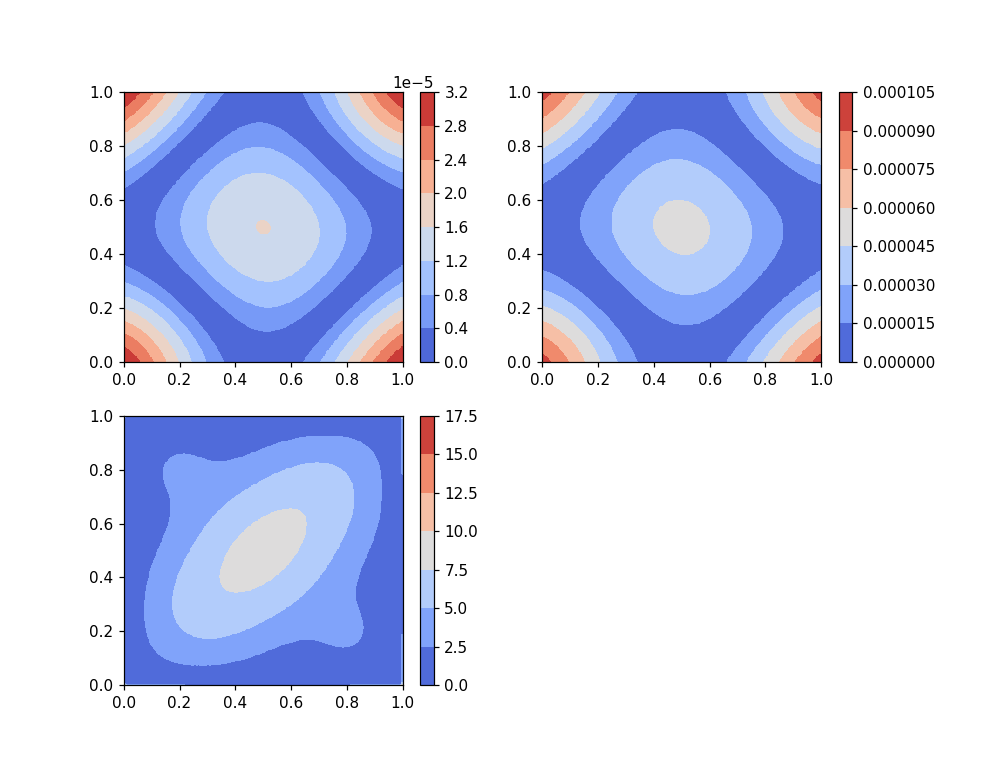

In [21]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 7))

i_GEp.interpolate(abs(i_GEp))
i_GEh.interpolate(abs(i_GEh))
i_DQ.interpolate(abs(i_DQ))

cb = plt.colorbar(tricontourf(i_GEp, axes=axes[0][0], cmap='coolwarm'), ax=axes[0][0])
cb = plt.colorbar(tricontourf(i_GEh, axes=axes[0][1], cmap='coolwarm'), ax=axes[0][1])
cb = plt.colorbar(tricontourf(i_DQ, axes=axes[1][0], cmap='coolwarm'), ax=axes[1][0])
axes[1][1].axis(False);